### Import Libraries

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import lightgbm as lgb
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from lightgbm.callback import early_stopping, log_evaluation
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

### Load Dataset

In [3]:
df =pd.read_csv('synthetic_scada_pro_7days_time_ordered.csv')
df = df.sort_values("timestamp").reset_index(drop=True)
dataframe=pd.DataFrame(df)
print(df.columns)
df=dataframe.copy()
df.info()
df.head()

Index(['timestamp', 'pressure', 'flow_rate', 'temperature', 'valve_status',
       'pump_state', 'pump_speed', 'compressor_state', 'energy_consumption',
       'alarm_triggered', 'target', 'event_type'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60478 entries, 0 to 60477
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   timestamp           60478 non-null  object 
 1   pressure            60478 non-null  float64
 2   flow_rate           60478 non-null  float64
 3   temperature         60478 non-null  float64
 4   valve_status        60478 non-null  float64
 5   pump_state          60478 non-null  float64
 6   pump_speed          60478 non-null  float64
 7   compressor_state    60478 non-null  float64
 8   energy_consumption  60478 non-null  float64
 9   alarm_triggered     60478 non-null  float64
 10  target              60478 non-null  float64
 11  event_type          604

,timestamp,pressure,flow_rate,temperature,valve_status,pump_state,pump_speed,compressor_state,energy_consumption,alarm_triggered,target,event_type
0,2025-01-01 00:00:00,39.967142,83.156623,5.537470,0.798742,0.728870,1279.553285,0.000000,23.833223,0.372787,0.0,normal
1,2025-01-01 00:00:10,33.617357,114.918760,4.972168,1.000000,0.995437,1433.997254,0.596744,23.629498,0.366304,0.0,normal
2,2025-01-01 00:00:20,41.476885,84.034801,4.524597,0.000000,1.000000,799.119564,0.200370,31.614705,0.512631,0.0,normal
3,2025-01-01 00:00:30,50.230299,55.096696,4.508468,0.586418,1.000000,485.097379,0.574527,42.432336,0.171342,0.0,normal
4,2025-01-01 00:00:40,32.658466,66.864312,4.732095,0.586541,0.514050,732.442127,0.563346,35.570096,0.000000,0.0,normal


### Exploratory Data Analysis (EDA)

In [4]:
# Basic Dataset Overview
print("Shape of dataset:", df.shape)
print("\nMissing values per column:\n", df.isnull().sum())
print("\nData types:\n", df.dtypes.value_counts())
display(df.describe(include="all").transpose())

Shape of dataset: (60478, 12)

Missing values per column:
 timestamp             0
pressure              0
flow_rate             0
temperature           0
valve_status          0
pump_state            0
pump_speed            0
compressor_state      0
energy_consumption    0
alarm_triggered       0
target                0
event_type            0
dtype: int64

Data types:
 float64    10
object      2
Name: count, dtype: int64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
timestamp,60478,60478,2025-01-07 23:59:30,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pressure,60478.0,NaN,NaN,NaN,33.317532,9.411625,7.155484,26.841504,32.951305,39.475515,77.746999
flow_rate,60478.0,NaN,NaN,NaN,67.517024,18.870813,7.989564,54.748506,67.126229,79.601003,162.359465
temperature,60478.0,NaN,NaN,NaN,5.177188,1.946744,0.0,3.881085,5.175633,6.469385,14.510921
valve_status,60478.0,NaN,NaN,NaN,0.499613,0.259001,0.0,0.31226,0.499139,0.686419,1.0
pump_state,60478.0,NaN,NaN,NaN,0.673937,0.242963,0.0,0.509126,0.693836,0.875469,1.0
pump_speed,60478.0,NaN,NaN,NaN,999.204733,374.104321,0.0,747.450956,1001.148863,1248.45312,2000.0
compressor_state,60478.0,NaN,NaN,NaN,0.590857,0.255651,0.0,0.412165,0.601539,0.784837,1.0
energy_consumption,60478.0,NaN,NaN,NaN,24.461899,9.1131,4.319368,18.248099,24.260995,30.440443,65.194191
alarm_triggered,60478.0,NaN,NaN,NaN,0.244033,0.222098,0.0,0.038269,0.206048,0.386026,1.0


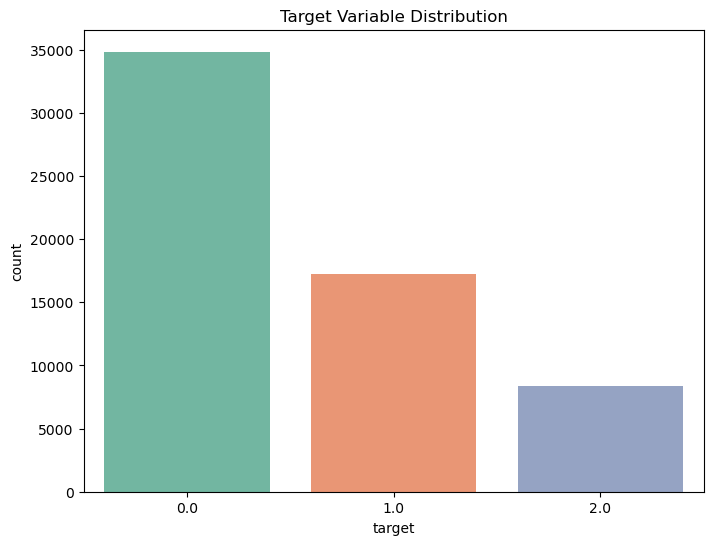

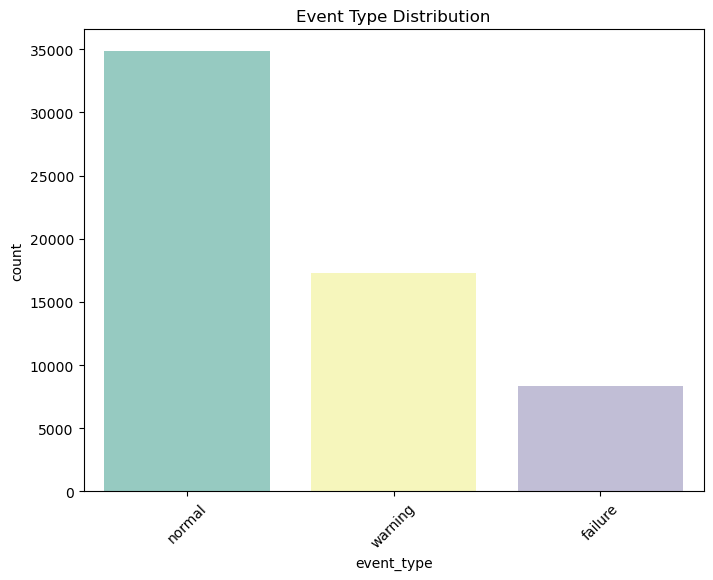

In [66]:
# Distribution of Target Variable
plt.figure(figsize=(8,6))
sns.countplot(x="target", data=df, palette="Set2")
plt.title("Target Variable Distribution")
plt.show()

# Event Type Distribution
plt.figure(figsize=(8,6))
sns.countplot(x="event_type", data=df, palette="Set3")
plt.title("Event Type Distribution")
plt.xticks(rotation=45)
plt.show()

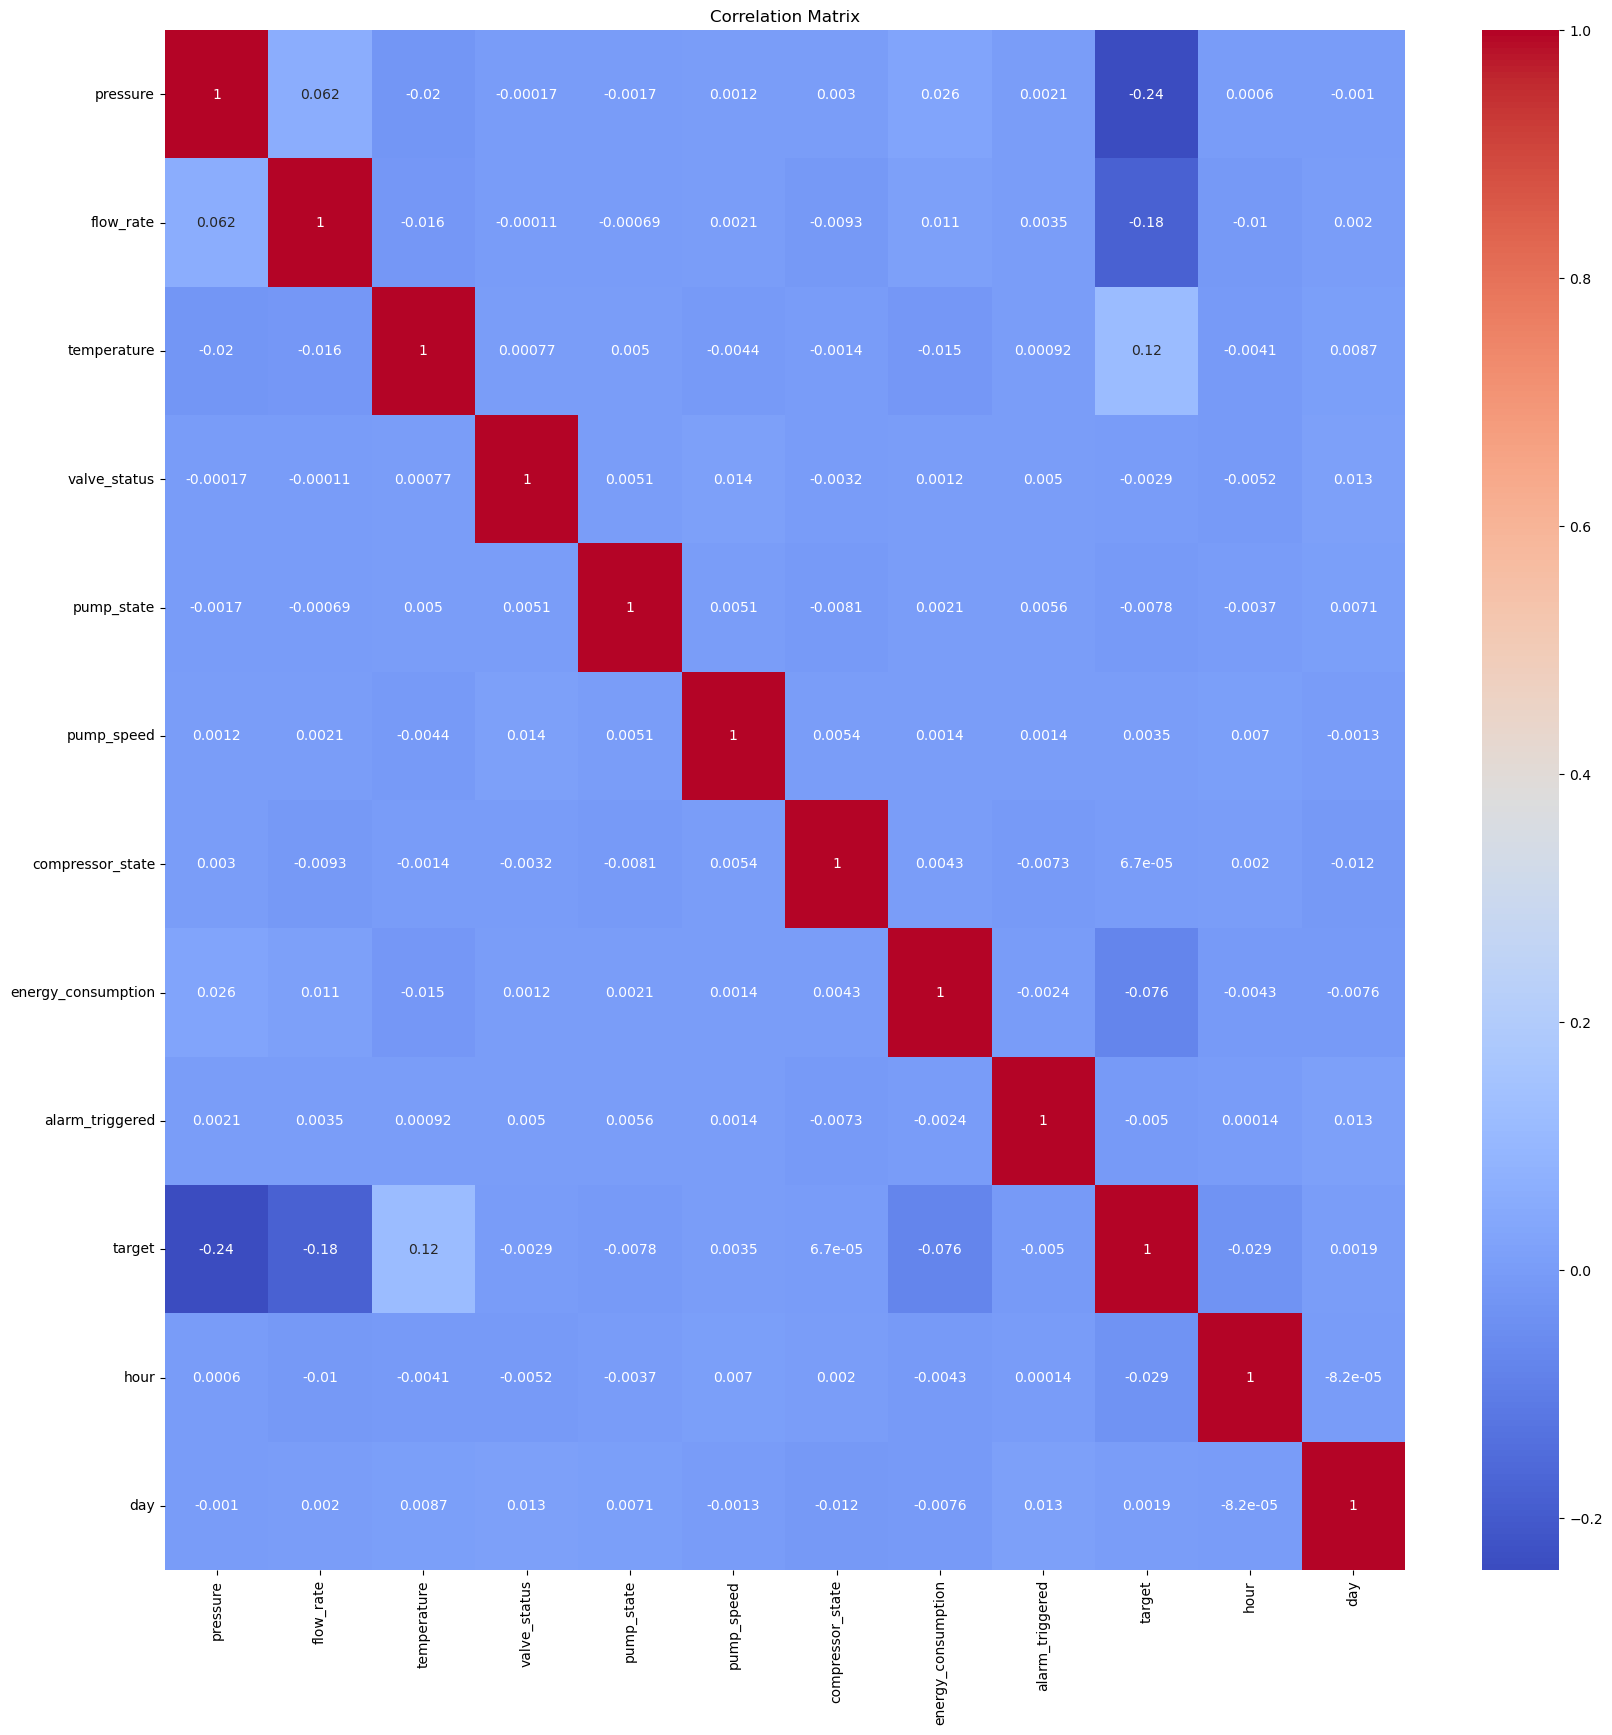

In [68]:
# Correlation Heatmap (Numerical Features)
num_cols=df.select_dtypes(include=['float','int'])
cor=num_cols.corr()
plt.figure(figsize=(20,20))
plt.title("Correlation Matrix")
sns.heatmap(cor,annot=True,cmap='coolwarm')
plt.show()

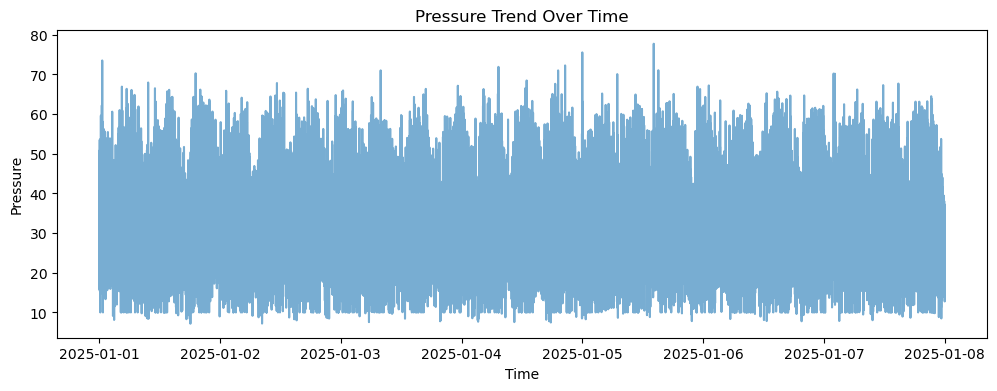

In [58]:
#Time Series Trend Example (Pressure over time)
plt.figure(figsize=(12,4))
plt.plot(pd.to_datetime(df["timestamp"]), df["pressure"], alpha=0.6)
plt.title("Pressure Trend Over Time")
plt.xlabel("Time")
plt.ylabel("Pressure")
plt.show()

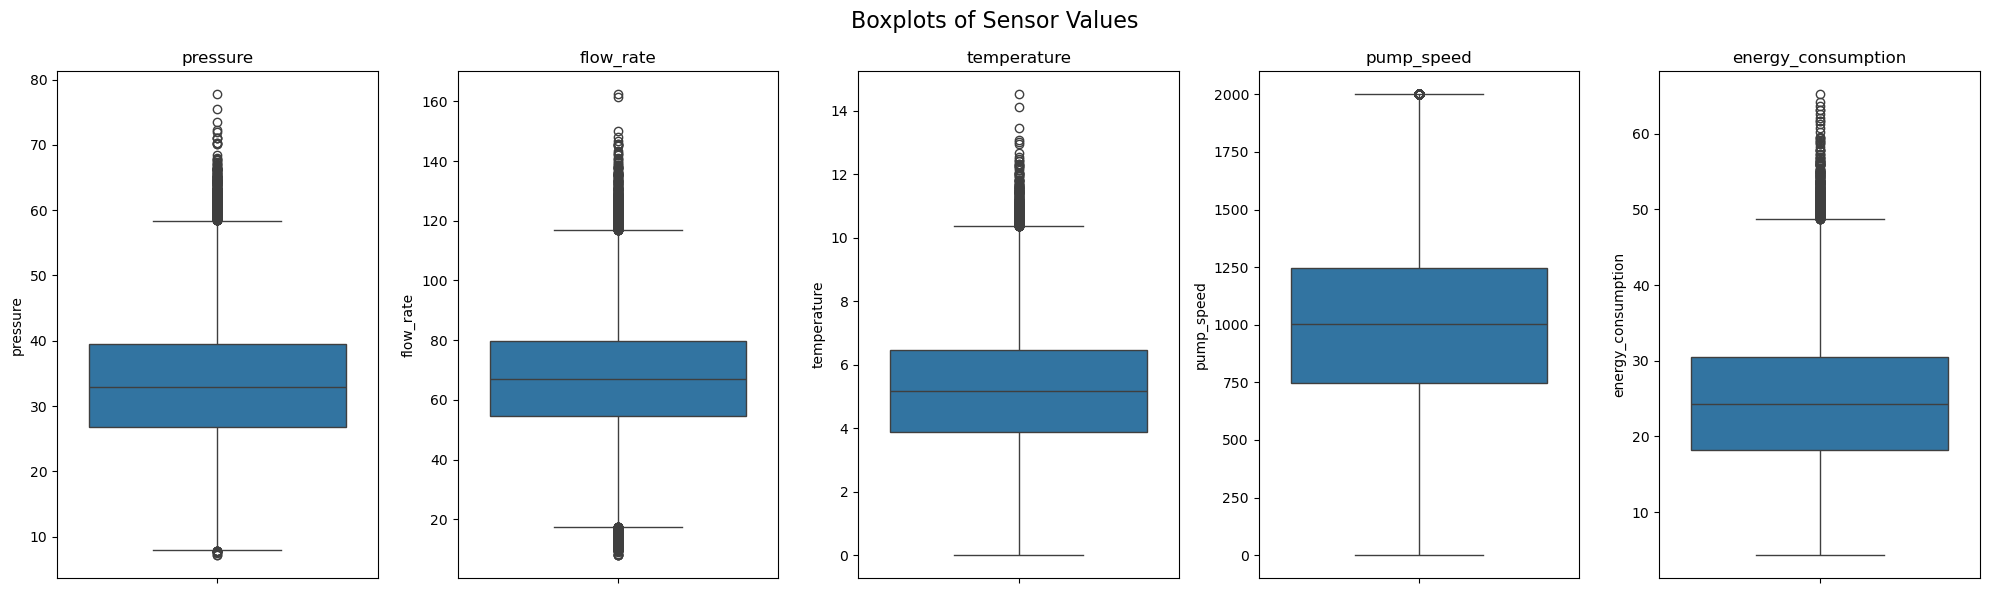

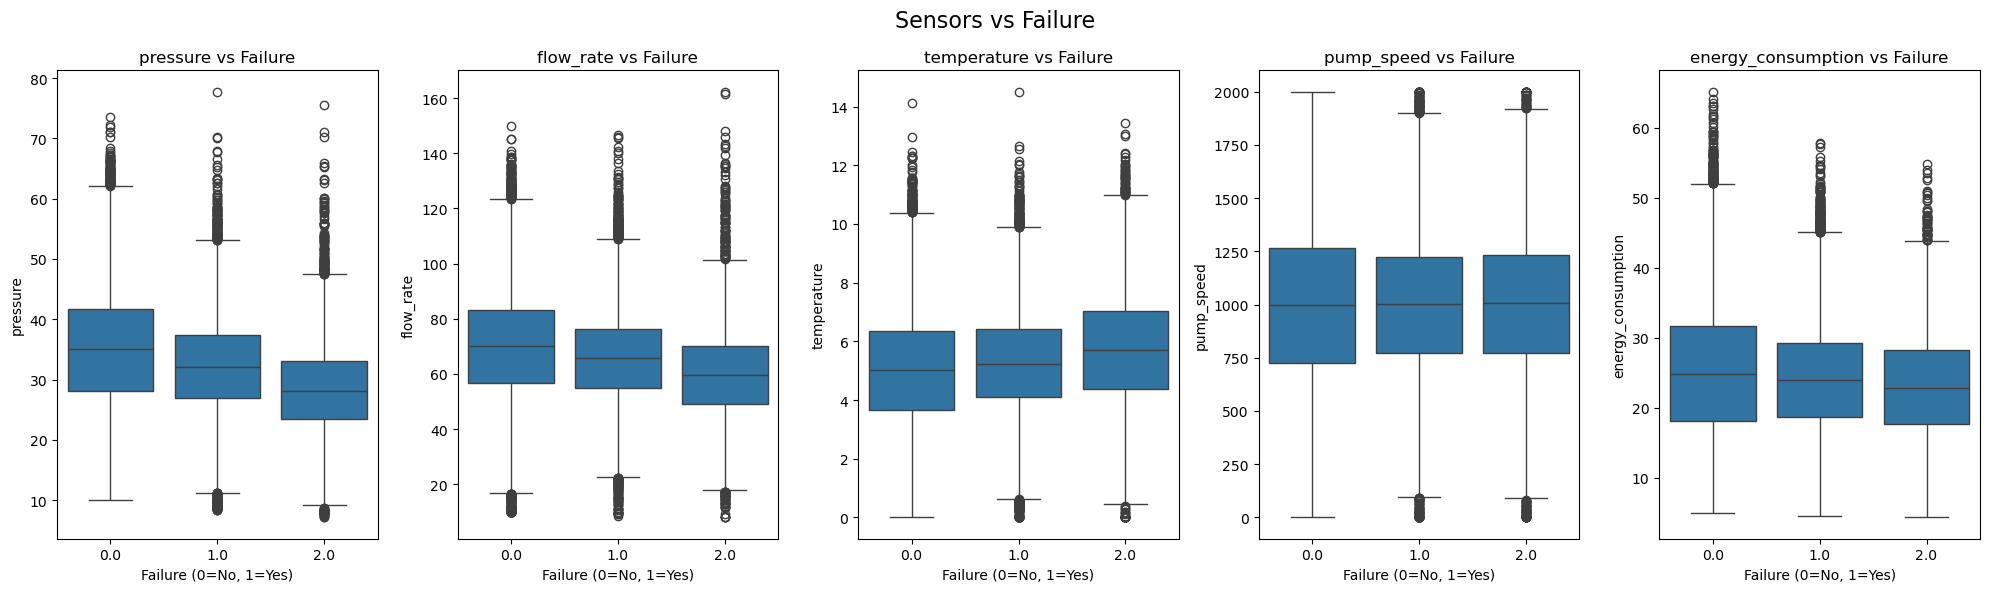

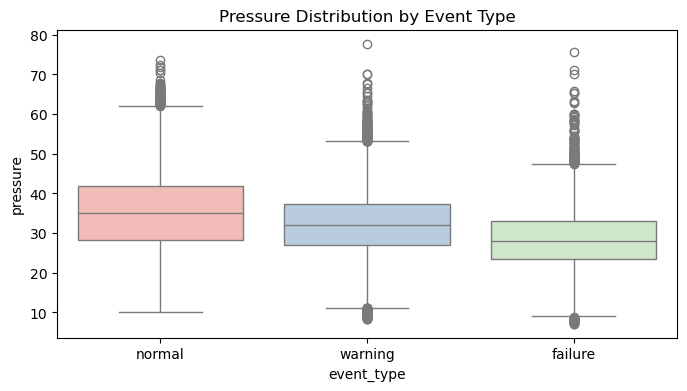

In [81]:
# Boxplot to check Outliers

sensors = ["pressure", "flow_rate", "temperature", "pump_speed", "energy_consumption"]
fig, axes = plt.subplots(1, len(sensors), figsize=(20,6))
for i, col in enumerate(sensors):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(f"{col}")
plt.suptitle("Boxplots of Sensor Values", fontsize=16)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, len(sensors), figsize=(20,6))
for i, col in enumerate(sensors):
    sns.boxplot(x="target", y=col, data=df, ax=axes[i])
    axes[i].set_title(f"{col} vs Failure")
    axes[i].set_xlabel("Failure (0=No, 1=Yes)")
plt.suptitle("Sensors vs Failure", fontsize=16)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(x="event_type", y="pressure", data=df, palette="Pastel1")
plt.title("Pressure Distribution by Event Type")
plt.show()

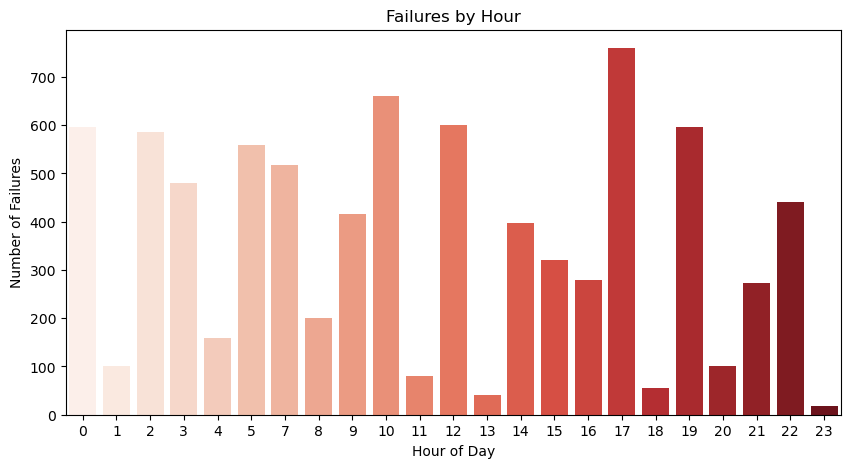

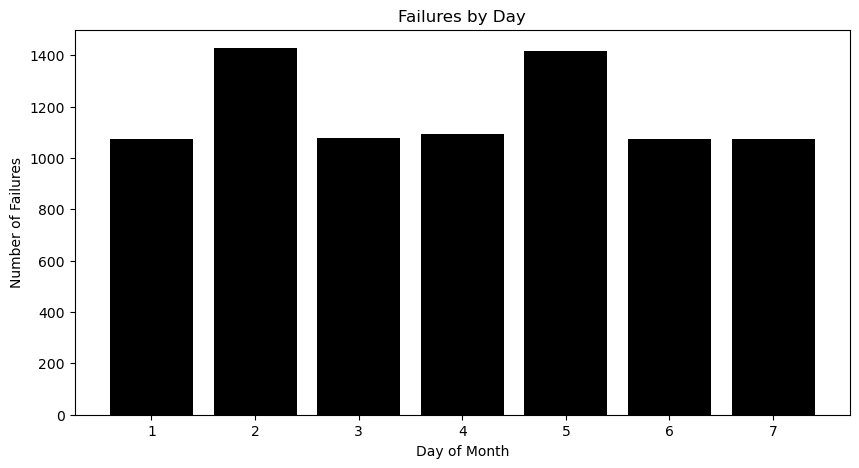

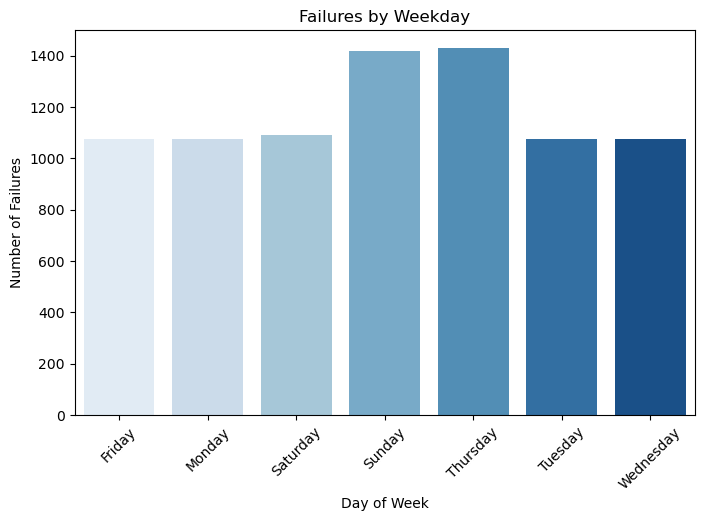

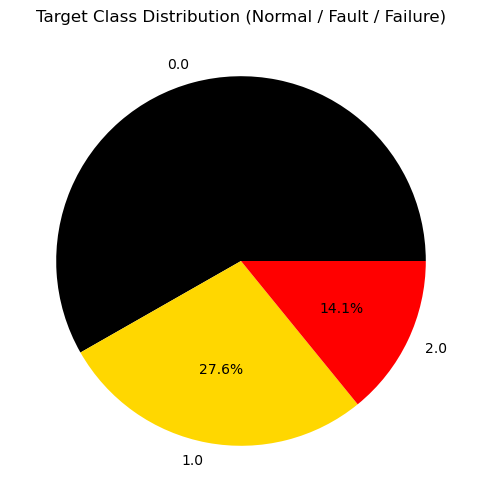

In [32]:
# Failure Analysis

# Ensure timestamp is datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract time features
if 'hour' not in df.columns:
    df['hour'] = df['timestamp'].dt.hour
if 'day' not in df.columns:
    df['day'] = df['timestamp'].dt.day
if 'weekday' not in df.columns:
    df['weekday'] = df['timestamp'].dt.day_name()

# Filter failures (target = 2)
failures = df[df['target'] == 2]

# Failures by Hour
failure_by_hours = failures.groupby('hour')['target'].count()
plt.figure(figsize=(10,5))
sns.barplot(x=failure_by_hours.index, y=failure_by_hours.values, palette="Reds")
plt.title("Failures by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Failures")
plt.show()

# Failures by Day
failure_by_day = failures.groupby('day')['target'].count()
plt.figure(figsize=(10,5))
plt.bar(failure_by_day.index, failure_by_day.values, color="black")
plt.title("Failures by Day")
plt.xlabel("Day of Month")
plt.ylabel("Number of Failures")
plt.show()

# Failures by Weekday
failure_by_weekday = failures.groupby('weekday')['target'].count()
plt.figure(figsize=(8,5))
sns.barplot(x=failure_by_weekday.index, y=failure_by_weekday.values, palette="Blues")
plt.title("Failures by Weekday")
plt.xlabel("Day of Week")
plt.ylabel("Number of Failures")
plt.xticks(rotation=45)
plt.show()

# Failure Distribution Pie Chart
failure_counts = df['target'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(failure_counts, labels=failure_counts.index, autopct='%1.1f%%', 
        colors=["black", "gold", "red"])
plt.title("Target Class Distribution (Normal / Fault / Failure)")
plt.show()

### Data Preprocessing & Feature Engineering

In [24]:
# Define Time Parameters
STEP_SIZE = 10                  # each row = 10 seconds
HORIZON_SECONDS = 2 * 60 * 60   # 2 hours = 7200 seconds
HORIZON = HORIZON_SECONDS // STEP_SIZE  # number of steps = 720

# Create Shifted Target (fault after 2 hours)
df["target_shifted"] = df["target"].shift(-HORIZON)
df.dropna(subset=["target_shifted"], inplace=True)
df["target_shifted"] = df["target_shifted"].astype(int)

# Select Important Sensor Columns
sensor_cols = ["pressure", "flow_rate", "temperature", 
               "pump_speed", "energy_consumption"]

# Generate Lag and Rolling Features
feature_frames = []

# Lag Features
LAGS = [1, 3, 6, 12, 30, 60, 120, 360]
for col in sensor_cols:
    for lag in LAGS:
        feature_frames.append(df[col].shift(lag).rename(f"{col}_lag{lag}"))

# Rolling Window Features
WINDOWS = [30, 60, 120, 360]
for col in sensor_cols:
    for w in WINDOWS:
        feature_frames.append(df[col].shift(1).rolling(window=w).mean().rename(f"{col}_rollmean{w}"))
        feature_frames.append(df[col].shift(1).rolling(window=w).std().rename(f"{col}_rollstd{w}"))
        feature_frames.append(df[col].shift(1).rolling(window=w).min().rename(f"{col}_rollmin{w}"))
        feature_frames.append(df[col].shift(1).rolling(window=w).max().rename(f"{col}_rollmax{w}"))

# Merge all generated features into main DataFrame
features_df = pd.concat(feature_frames, axis=1)
df = pd.concat([df, features_df], axis=1)

# Add Time-based Features
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df["hour"] = df["timestamp"].dt.hour
df["dayofweek"] = df["timestamp"].dt.dayofweek

# Data Cleaning
df = df.dropna().reset_index(drop=True)

### Define Features and Train/Test Split

In [25]:
# Define Features (X) and Target (y)
X = df.drop(columns=["target", "target_shifted", "timestamp", "event_type"])
y = df["target_shifted"]

print("Final dataset shape:", X.shape, y.shape)

print("Final dataset shape (with all cols):", df.shape)
X = df.drop(columns=["timestamp","target","event_type","target_shifted"])
y = df["target_shifted"]

# Train/Test Split (Time-based, 80/20)
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

Final dataset shape: (58318, 256) (58318,)
Final dataset shape (with all cols): (58318, 260)


### Handle Class Imbalance + Train LightGBM

In [33]:
# prevent value error
X_train = X_train.select_dtypes(include=['float','int'])
X_test  = X_test.select_dtypes(include=['float','int'])

# Handle Class Imbalance (SMOTE)
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# Train LightGBM (Baseline Model)
X_train_bal = X_train_bal.loc[:, ~X_train_bal.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]

model = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    class_weight="balanced",
    random_state=42
)
model.fit(X_train_bal, y_train_bal)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))
print(confusion_matrix(y_test, y_pred))

# Save Feature Columns
feature_cols = df.drop(columns=["timestamp","target","event_type","target_shifted"]).columns.tolist()
joblib.dump(feature_cols, "feature_columns.pkl")
print("Feature engineering columns saved successfully")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33162
[LightGBM] [Info] Number of data points in the train set: 81738, number of used features: 134
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
              precision    recall  f1-score   support

           0     0.9504    0.6715    0.7870      7226
           1     0.5484    0.9209    0.6874      3007
           2     0.8344    0.8805    0.8569      1431

    accuracy                         0.7614     11664
   macro avg     0.7778    0.8243    0.7771     11664
weighted avg     0.8326    0.7614    0.7699     11664

[[4852 2124  250]
 [ 238 2769    0]
 [  15  156 1260]]
Feature engineering columns saved successfully


### Train Multiple Models (LGBM, CatBoost, XGBoost)

In [34]:
X = X.loc[:, ~X.columns.duplicated()].copy()    # drop the duplicate col. before training
X = X.select_dtypes(include=['float','int','bool'])  #to prevent value error

# Train/Test Split (no shuffle, time series)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Compute Class Weights
classes = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
print("Class Weights:", class_weights)

# LightGBM
print("\n================ LightGBM ================")
lgb_model = lgb.LGBMClassifier(
    class_weight=class_weights,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)
print(classification_report(y_test, y_pred_lgb))
print(confusion_matrix(y_test, y_pred_lgb))

# CatBoost
print("\n================ CatBoost ================")
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=8,
    class_weights=[class_weights.get(i,1) for i in range(len(classes))],
    verbose=0,
    random_state=42
)
cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_test)
print(classification_report(y_test, y_pred_cat))
print(confusion_matrix(y_test, y_pred_cat))

# XGBoost
print("\n================ XGBoost ================")
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=len(classes),
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1, 
    random_state=42,
    tree_method="hist"
)
xgb_model.fit(X_train, y_train, sample_weight=[class_weights[val] for val in y_train])
y_pred_xgb = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

Class Weights: {np.int64(0): np.float64(0.5707749149722283), np.int64(1): np.float64(1.2003190285067407), np.int64(2): np.float64(2.41031204794379)}

================ LightGBM ================
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32233
[LightGBM] [Info] Number of data points in the train set: 46654, number of used features: 134
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
              precision    recall  f1-score   support

           0       0.93      0.69      0.79      7226
           1       0.55      0.88      0.68      3007
           2       0.82      0.88      0.85      1431

    accuracy                           0.76     11664
   macro avg       0.77      0.82      0.77     11664
weighted avg       0.82     

### Ensemble with Voting Classifier

In [35]:
# Ensemble: Voting Classifier (Soft Voting)
lgb_model = lgb.LGBMClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
cat_model = CatBoostClassifier(verbose=0, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lgb', lgb_model),
        ('xgb', xgb_model),
        ('cat', cat_model)
    ],
    voting='soft'
)

voting_clf.fit(X_train, y_train)   # training
y_pred = voting_clf.predict(X_test)   # predicting

print(classification_report(y_test, y_pred))

joblib.dump(voting_clf, "fault_detection_voting_model.pkl")   #save as joblib
print("Model saved as fault_detection_voting_model.pkl")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32233
[LightGBM] [Info] Number of data points in the train set: 46654, number of used features: 134
[LightGBM] [Info] Start training from score -0.537852
[LightGBM] [Info] Start training from score -1.281200
[LightGBM] [Info] Start training from score -1.978369
              precision    recall  f1-score   support

           0       0.90      0.68      0.78      7226
           1       0.54      0.84      0.66      3007
           2       0.79      0.85      0.82      1431

    accuracy                           0.74     11664
   macro avg       0.74      0.79      0.75     11664
weighted avg       0.79      0.74      0.75     11664

Model saved as fault_detection_voting_model.pkl


### Hyperparameter Tuning (LightGBM Random Search)

In [39]:
# Define Model
lgbm = LGBMClassifier(
    objective="multiclass",
    num_class=3,
    random_state=42,
     verbose=-1   # to hide the intire printing
)    

# Define Parameters
param_dist = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [-1, 5, 10],
    "num_leaves": [15, 31, 63]
}       

# Randomized Search
rand_search = RandomizedSearchCV(
    lgbm,
    param_distributions=param_dist,
    n_iter=5,          #to try faster
    cv=2,              
    scoring="f1_macro",    #use f1 macro
    verbose=0,
    n_jobs=1,
    random_state=42
)

callbacks = [
    early_stopping(stopping_rounds=20),
    log_evaluation(0)   # to privint printing alot
]

rand_search.fit(
    X_train_bal, y_train_bal,
    eval_set=[(X_test, y_test)],
    eval_metric="multi_logloss"
)

print("Best Params:", rand_search.best_params_)

# Evaluate Best Model
best_model = rand_search.best_estimator_

y_pred = best_model.predict(X_test)

print("\n Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("F1 Macro:", f1_score(y_test, y_pred, average="macro"))

Best Params: {'num_leaves': 15, 'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.05}

 Classification Report:
              precision    recall  f1-score   support

           0     0.9667    0.6787    0.7975      7226
           1     0.5638    0.9478    0.7070      3007
           2     0.8236    0.8840    0.8527      1431

    accuracy                         0.7732     11664
   macro avg     0.7847    0.8368    0.7857     11664
weighted avg     0.8453    0.7732    0.7809     11664

F1 Macro: 0.7857323257032375


### Threshold Tuning

In [40]:
# Get predicted probabilities from the model
y_proba = best_model.predict_proba(X_test)

# Default prediction = argmax (choose the class with highest probability)
y_pred_default = np.argmax(y_proba, axis=1)

# Apply custom threshold for Class 0
# If probability of Class 0 >= threshold → classify as Class 0 (Normal)
# Otherwise → classify as the next most likely class (1 = Fault, 2 = Critical)
threshold = 0.45   # Can be adjusted (e.g., 0.4 / 0.5) to balance sensitivity vs. specificity
y_pred_custom = []
for probs in y_proba:
    if probs[0] >= threshold:
        y_pred_custom.append(0)
    else:
        y_pred_custom.append(np.argmax(probs[1:]) + 1)
y_pred_custom = np.array(y_pred_custom)

# Evaluation (Default vs. Custom Threshold)
# Compare default argmax classification with custom threshold results
print("Default Classification Report:")
print(classification_report(y_test, y_pred_default, digits=4))

print("Tuned Threshold Classification Report:")
print(classification_report(y_test, y_pred_custom, digits=4))

print("Confusion Matrix (Tuned):")
print(confusion_matrix(y_test, y_pred_custom))

# Save Final Tuned Model
joblib.dump(best_model, "final_tuned_model.pkl")
print("Final tuned model saved successfully")

Default Classification Report:
              precision    recall  f1-score   support

           0     0.9667    0.6787    0.7975      7226
           1     0.5638    0.9478    0.7070      3007
           2     0.8236    0.8840    0.8527      1431

    accuracy                         0.7732     11664
   macro avg     0.7847    0.8368    0.7857     11664
weighted avg     0.8453    0.7732    0.7809     11664

Tuned Threshold Classification Report:
              precision    recall  f1-score   support

           0     0.9608    0.6823    0.7979      7226
           1     0.5626    0.9371    0.7031      3007
           2     0.8301    0.8840    0.8562      1431

    accuracy                         0.7727     11664
   macro avg     0.7845    0.8345    0.7857     11664
weighted avg     0.8421    0.7727    0.7806     11664

Confusion Matrix (Tuned):
[[4930 2037  259]
 [ 189 2818    0]
 [  12  154 1265]]
Final tuned model saved successfully


### Confusion Matrix Visualization

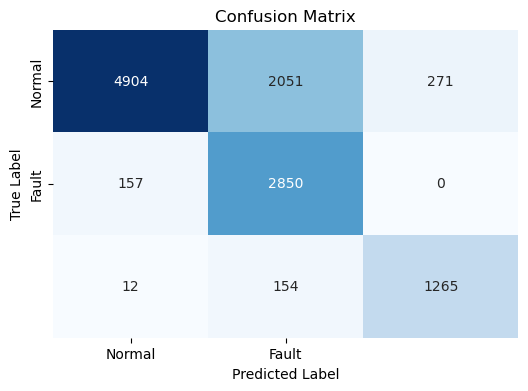

In [41]:
cm = confusion_matrix(y_test, y_pred)

# create a heatmap to visualize confusion matrix results
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False,
            xticklabels=["Normal", "Fault"], 
            yticklabels=["Normal", "Fault"])

# Add axis labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### Evaluation Metrics: Accuracy, Precision, Recall, F1-score

In [42]:
# Compute overall accuracy
accuracy = accuracy_score(y_test, y_pred)

# Compute precision, recall, and F1-score for each class separately
precision = precision_score(y_test, y_pred, average=None, labels=[0,1,2])
recall = recall_score(y_test, y_pred, average=None, labels=[0,1,2])
f1 = f1_score(y_test, y_pred, average=None, labels=[0,1,2])

# Print overall accuracy
print("Accuracy: {:.4f}".format(accuracy))

# Print per-class metrics in a clear format
print("\nPer-class metrics:")
for i, cls in enumerate(["Normal", "Fault", "Critical"]):
    print(f"{cls}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1-score={f1[i]:.4f}")

# Provides a full summary including macro/weighted averages
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Normal", "Fault", "Critical"]))


Accuracy: 0.7732

Per-class metrics:
Normal: Precision=0.9667, Recall=0.6787, F1-score=0.7975
Fault: Precision=0.5638, Recall=0.9478, F1-score=0.7070
Critical: Precision=0.8236, Recall=0.8840, F1-score=0.8527

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.68      0.80      7226
       Fault       0.56      0.95      0.71      3007
    Critical       0.82      0.88      0.85      1431

    accuracy                           0.77     11664
   macro avg       0.78      0.84      0.79     11664
weighted avg       0.85      0.77      0.78     11664

